### Treść zadania

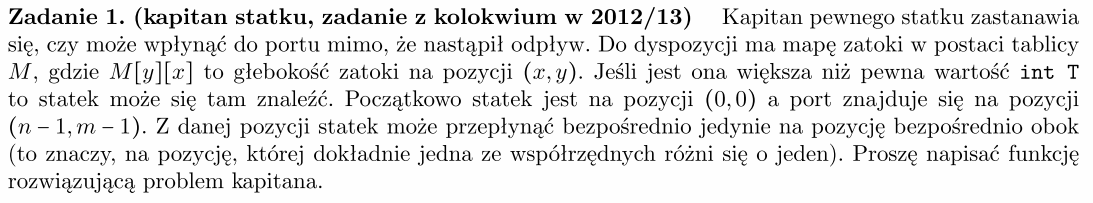

### Omówienie algorytmu

Proste zastosowanie algorytmu DFS z dodatkowym warunkiem w postaci głębokości. Jeżeli głębokość jest wystarczająca i dane pole nie było wcześniej odwiedzone, możemy je odwiedzić. W przeciwnym razie, pomijamy to pole.

### Złożoność

###### Obliczeniowa:
$ O(V^2) $
###### Pamięciowa:
$ O(1) $

### Implementacja

In [1]:
def sail(G: 'grid of water depth', t: 'min depth required') -> bool:
    n = len(G)
    m = len(G[0])
    
    def dfs(i, j):
        if i == n - 1 and j == m - 1: return True
        
        G[i][j] *= -1  # Mark this field as visited
        if i > 0 and G[i - 1][j] > t and dfs(i - 1, j): return True
        if i < n - 1 and G[i + 1][j] > t and dfs(i + 1, j): return True
        if j > 0 and G[i][j - 1] > t and dfs(i, j - 1): return True
        if j < m - 1 and G[i][j + 1] > t and dfs(i, j + 1): return True
        
        return False
    
    # Check if we are already stranded
    if G[0][0] <= t: return False

    # Check if we can reach the end from the G[0][0]
    res = dfs(0, 0)
    
    # Fix the grid (restore original depths)
    for i in range(n):
        for j in range(m):
            G[i][j] = abs(G[i][j])
            
    return res

###### Kilka testów

In [2]:
from random import randint

def test(n, m, *, min_d=0, max_d=100):
    G = [[randint(min_d, max_d) for _ in range(n)] for _ in range(m)]
    t = max(min(randint(min_d, max_d), G[0][0] - 1), 0)
    just = max(len(str(d)) for row in G for d in row)
    print('Required depth:', t)
    print(f'Grid {n} x {m}:')
    print(*(' '.join(map(lambda v: str(v).ljust(just), row)) for row in G), sep='\n')
    res = sail(G, t)
    print('Can reach?', res)

In [3]:
test(4, 3)

Required depth: 1
Grid 4 x 3:
72 19 78 89
59 37 90 65
84 27 15 64
Can reach? True


### (Dodatkowo) Zwracanie trasy

Zauważmy, że my nie szukamy najkrótszej trasy, więc może ona być dowolna (czasem nawet przechodzić przez wszystkie pola).

#### W postaci kierunków kolejnych ruchów:

In [4]:
def sail_path(G: 'grid of water depth', t: 'min depth required'):
    n = len(G)
    m = len(G[0])
    
    path = []
    
    def dfs(i, j):
        if i == n - 1 and j == m - 1: return True
        
        G[i][j] *= -1  # Mark this field as visited
        if i > 0 and G[i - 1][j] > t and dfs(i - 1, j): 
            path.append('U')
            return True
        if i < n - 1 and G[i + 1][j] > t and dfs(i + 1, j): 
            path.append('D')
            return True
        if j > 0 and G[i][j - 1] > t and dfs(i, j - 1): 
            path.append('L')
            return True
        if j < m - 1 and G[i][j + 1] > t and dfs(i, j + 1): 
            path.append('R')
            return True
        
        return False
    
    # Check if we are already stranded
    if G[0][0] <= t: return None

    # Check if we can reach the end from the G[0][0]
    res = dfs(0, 0)
    
    # Fix the grid (restore original depths)
    for i in range(n):
        for j in range(m):
            G[i][j] = abs(G[i][j])
            
    return None if not res else path[::-1]  # Reverse a path to get the original order

###### Kilka testów

In [5]:
from random import randint

def test(n, m, *, min_d=0, max_d=100):
    G = [[randint(min_d, max_d) for _ in range(n)] for _ in range(m)]
    t = max(min(randint(min_d, max_d), G[0][0] - 1), 0)
    just = max(len(str(d)) for row in G for d in row)
    print('Required depth:', t)
    print(f'Grid {n} x {m}:')
    print(*(' '.join(map(lambda v: str(v).ljust(just), row)) for row in G), sep='\n')
    res = sail_path(G, t)
    print('Found path?', bool(res))
    if res:
        print('Path:')
        print(*res, sep=' -> ')

In [6]:
test(3, 4)

Required depth: 17
Grid 3 x 4:
18 59 26
48 86 87
90 94 58
64 83 67
Found path? True
Path:
D -> D -> D -> R -> U -> U -> U -> R -> D -> D -> D


### (Dodatkowo) Znajdowanie najkrótszej trasy

Tym razem algorytm jest nieco inny i musimy zastosować BFS, w celu znalezienia najkrótszej trasy, którą możemy dopłynąć do zatoki. W przypadku algorytmu BFS niestety nie ma stosu rekurencyjnego, więc tracimy wszystkie poprzednie kroki. Musimy więc zapamiętywać, jaką trasą przeszliśmy do danego pola w kwadratowej tablicy, więc żłożoność pamięciowa wzrasta nam do $ O(n \cdot m) $

#### Trasa w postaci kierunków ruchu

In [7]:
from queue import Queue


def sail_shortest_path(G: 'grid of water depth', t: 'min depth required'):
    if G[0][0] <= t: return None
    
    n = len(G)
    m = len(G[0])
    
    moves = [[''] * m for _ in range(n)]
    # I use two separate queues for both coordinates as it is faster to dequeue
    # only one value at a time than a tuple which then must be unpacked
    i_q = Queue()
    j_q = Queue()
    i_q.put(0)
    j_q.put(0)
    moves[0][0] = ' '
    
    while not i_q.empty():
        i = i_q.get()
        j = j_q.get()
        # Check if we reached the end
        if i == n - 1 and j == m - 1: break
        # Otherwise, visit all unvisited neighbours
        if i > 0 and G[i - 1][j] > t and not moves[i - 1][j]:
            moves[i - 1][j] = 'U'
            i_q.put(i - 1)
            j_q.put(j)
        if j > 0 and G[i][j - 1] > t and not moves[i][j - 1]:
            moves[i][j - 1] = 'L'
            i_q.put(i)
            j_q.put(j - 1)
        if i < n - 1 and G[i + 1][j] > t and not moves[i + 1][j]:
            moves[i + 1][j] = 'D'
            i_q.put(i + 1)
            j_q.put(j)
        if j < m - 1 and G[i][j + 1] > t and not moves[i][j + 1]:
            moves[i][j + 1] = 'R'
            i_q.put(i)
            j_q.put(j + 1)
        
    # Return None if cannot reach the end
    if not moves[n - 1][m - 1]: return None
        
#     print(*moves, sep='\n')
#     Restore path
    path = []
    i = n - 1
    j = m - 1
    while i > 0 or j > 0:
        mv = moves[i][j]
        path.append(mv)
        if   mv == 'D': i -= 1
        elif mv == 'U': i += 1
        elif mv == 'R': j -= 1
        elif mv == 'L': j += 1
            
    return path[::-1]

###### Kilka testów

In [8]:
from random import randint

def test(n, m, *, min_d=0, max_d=100):
    G = [[randint(min_d, max_d) for _ in range(n)] for _ in range(m)]
    t = max(min(randint(min_d, max_d), G[0][0] - 1), 0)
    just = max(len(str(d)) for row in G for d in row)
    print('Required depth:', t)
    print(f'Grid {n} x {m}:')
    print(*(' '.join(map(lambda v: str(v).ljust(just), row)) for row in G), sep='\n')
    res = sail_shortest_path(G, t)
    print('Found path?', bool(res))
    if res:
        print('Shortest path:')
        print(*res, sep=' -> ')

In [9]:
test(10, 10)

Required depth: 1
Grid 10 x 10:
58 36 88 88 2  49 13 22 12 51
92 53 90 56 15 95 34 4  35 72
80 59 97 48 89 91 13 15 77 99
80 18 65 32 88 26 9  32 47 15
46 64 72 75 94 92 54 90 37 89
44 28 84 5  93 95 85 98 16 34
55 33 41 90 32 69 14 29 82 11
55 0  92 50 46 58 62 54 10 55
60 82 43 56 47 42 87 85 55 26
30 34 60 90 34 45 5  4  1  26
Found path? True
Shortest path:
D -> D -> D -> D -> D -> D -> D -> D -> R -> R -> R -> R -> R -> R -> R -> R -> R -> D


In [10]:
t = 35
G = [
    [36, 24, 7, 41, 71, 59, 25, 81, 36, 81],
    [74, 15, 10, 100, 91, 29, 46, 71, 61, 24],
    [66, 22, 63, 90, 52, 66, 37, 35, 4, 25],
    [52, 26, 64, 49, 20, 76, 51, 71, 81, 27],
    [40, 98, 18, 17, 80, 38, 51, 61, 19, 55],
    [85, 81, 33, 26, 42, 21, 76, 66, 20, 46],
    [20, 88, 93, 66, 84, 0, 70, 70, 4, 51],
    [16, 80, 2, 8, 4, 58, 33, 64, 81, 24],
    [77, 7, 86, 37, 86, 75, 81, 68, 45, 43],
    [73, 100, 75, 44, 30, 48, 47, 23, 55, 60]
]
print(' -> '.join(sail_shortest_path(G, t)))

D -> D -> D -> D -> D -> R -> D -> R -> R -> R -> U -> U -> R -> R -> D -> D -> R -> D -> D -> R -> D -> R


##### Helpers:

In [11]:
n = 10; m = 10
min_d = 0; max_d = 100
while True:
    G = [[randint(min_d, max_d) for _ in range(n)] for _ in range(m)]
    t = max(min(randint(min_d, max_d), G[0][0] - 1), 0)
    res = sail_shortest_path(G, t)
    if res and 'U' in res:
        print(t)
        print(*G, sep='\n')
        break

35
[36, 10, 35, 16, 85, 49, 88, 80, 96, 66]
[37, 83, 84, 63, 36, 38, 21, 98, 55, 10]
[93, 35, 35, 9, 32, 56, 76, 16, 39, 81]
[44, 74, 20, 46, 50, 24, 43, 39, 7, 55]
[3, 49, 7, 95, 58, 15, 19, 33, 53, 82]
[44, 56, 37, 35, 23, 34, 80, 43, 78, 12]
[64, 85, 3, 75, 93, 2, 79, 66, 79, 78]
[0, 33, 96, 57, 0, 59, 72, 80, 73, 86]
[39, 15, 2, 6, 39, 63, 35, 0, 91, 11]
[9, 24, 51, 76, 53, 96, 57, 15, 94, 90]
